# Overview
The notebook packages up a pretrained model and exports it as javascript, based loosely on the [convert_keras.py](https://github.com/mil-tokyo/webdnn/blob/master/bin/convert_keras.py) script

In [1]:
import argparse
import importlib.util
import inspect
import os
import sys
sys.setrecursionlimit(10000)  # workaround for deep copying large graph
import traceback
from os import path

import keras

from webdnn.backend import generate_descriptor
from webdnn.frontend.keras import KerasConverter
from webdnn.graph import traverse
from webdnn.graph.placeholder import Placeholder
from webdnn.graph.shape import Shape
from webdnn.graph.traverse import dump_dot
from webdnn.util import flags, console

Using TensorFlow backend.
/srv/conda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.applications import ResNet50
pretrained_model = ResNet50(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))

102858752/102853048 [==============================] - 4s 0us/step


In [6]:
input_shapes = [(1,)+pretrained_model.get_input_shape_at(0)[1:]]
print(input_shapes)
model = pretrained_model

[(1, 224, 224, 3)]


In [7]:
model.build(input_shape=None)
converter = KerasConverter(batch_size=input_shapes[0][0])
graph = converter.convert(model)
traverse.dump(graph)

In [9]:
for graph_input, input_shape in zip(graph.inputs, input_shapes):
    for p1, p2 in zip(graph_input.shape, input_shape):
        if not Placeholder.check_resolved(p1) and Placeholder.check_resolved(p2):
            p1.value = Placeholder.force_int(p2)

        elif Placeholder.check_resolved(p1) and not Placeholder.check_resolved(p2):
            raise ValueError(f'Shape mismatch: expected:{input_shape}, real:{graph_input.shape}, {p1} != {p2}')

        elif Placeholder.check_resolved(p1) and Placeholder.check_resolved(p2):
            assert p1 == p2, f'Shape mismatch: expected:{input_shape}, real:{graph_input.shape}, {p1} != {p2}'

output_dir = path.join('.', "webdnn_graph_descriptor")
os.makedirs(output_dir, exist_ok=True)

ir_dot_path = path.join(output_dir, "ir.dot")
with open(ir_dot_path, "w") as f:
    f.write(dump_dot(graph))
console.stderr(f" Generating graph descriptor")

 Generating graph descriptor


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.383307 to fit


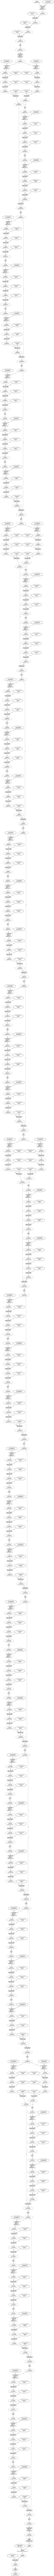

In [ ]:
from IPython.display import Image
!dot {ir_dot_path} -T png -o output.png
Image('output.png')

In [10]:
any_backend_failed = False
backends = 'fallback,webassembly,webgl,webgpu'.split(',')

for i, backend in enumerate(backends):
    console.stderr(f"BackendName: {console.colorize(backend, console.Color.Cyan)}")
    try:
        graph_exec_data = generate_descriptor(backend, graph, constant_encoder_name=None)
        graph_exec_data.save(output_dir)
    except Exception as ex:
        if flags.DEBUG:
            raise ex

        any_backend_failed = True
        console.error(f"Failed generating descriptor for {backend} backend")
        console.stderr(traceback.format_exc())
        continue

if any_backend_failed:
    raise ValueError('BackendFailed')
    # raise last_backend_exception

BackendName: fallback
BackendName: webassembly
Executing em++ command failed. Make sure emscripten is properly installed and environment variables are set.
Failed generating descriptor for webassembly backend
Traceback (most recent call last):
  File "<ipython-input-10-f434e3d359d6>", line 8, in <module>
    graph_exec_data.save(output_dir)
  File "/home/jovyan/.local/lib/python3.6/site-packages/webdnn/backend/webassembly/generator.py", line 50, in save
    self._compile_fallback_asmjs(dirname)
  File "/home/jovyan/.local/lib/python3.6/site-packages/webdnn/backend/webassembly/generator.py", line 99, in _compile_fallback_asmjs
    raise ex
  File "/home/jovyan/.local/lib/python3.6/site-packages/webdnn/backend/webassembly/generator.py", line 95, in _compile_fallback_asmjs
    subprocess.check_call(args, shell=self.platform_windows)
  File "/srv/conda/lib/python3.6/subprocess.py", line 291, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['

ValueError: BackendFailed

In [21]:
!ls -lh webdnn_graph_descriptor/

total 592M
-rw-r--r-- 1 jovyan jovyan 147K Feb 12 13:58 graph_fallback.json
-rw-r--r-- 1 jovyan jovyan  24K Feb 12 13:58 graph_webassembly.json
-rw-r--r-- 1 jovyan jovyan 2.0M Feb 12 13:58 graph_webgl_16384.json
-rw-r--r-- 1 jovyan jovyan 2.3M Feb 12 13:58 graph_webgl_4096.json
-rw-r--r-- 1 jovyan jovyan 2.1M Feb 12 13:58 graph_webgl_8192.json
-rw-r--r-- 1 jovyan jovyan 196K Feb 12 13:58 graph_webgpu.json
-rw-r--r-- 1 jovyan jovyan 111K Feb 12 13:58 ir.dot
-rw-r--r-- 1 jovyan jovyan  10K Feb 12 13:58 kernels_fallback.js
-rw-r--r-- 1 jovyan jovyan  33K Feb 12 13:58 kernels_webassembly.cpp
-rw-r--r-- 1 jovyan jovyan  61K Feb 12 13:58 kernels_webgpu.metal
-rw-r--r-- 1 jovyan jovyan  98M Feb 12 13:58 weight_fallback.bin
-rw-r--r-- 1 jovyan jovyan  98M Feb 12 13:58 weight_webassembly.bin
-rw-r--r-- 1 jovyan jovyan  98M Feb 12 13:58 weight_webgl_16384.bin
-rw-r--r-- 1 jovyan jovyan  98M Feb 12 13:58 weight_webgl_4096.bin
-rw-r--r-- 1 jovyan jovyan  98M Feb 12 13:58 weight_webgl_8192.bin
-rw-

# Download Files
Here you can download the compiled files for the model

In [25]:
from IPython.display import FileLinks
FileLinks('webdnn_graph_descriptor')

webdnn_graph_descriptor/
  weight_fallback.bin
  weight_webassembly.bin
  kernels_webassembly.cpp
  kernels_fallback.js
  graph_webassembly.json
  graph_webgl_8192.json
  graph_webgl_16384.json
  weight_webgl_16384.bin
  graph_fallback.json
  weight_webgl_4096.bin
  graph_webgpu.json
  ir.dot
  weight_webgpu.bin
  graph_webgl_4096.json
  kernels_webgpu.metal
  weight_webgl_8192.bin